# Dynamical Simulation for the Reputation Score

Reference: https://hackmd.io/8CSLDfKNSAyyl-OfEzOdDQ

## Depedences

In [262]:
import scipy.stats as st
from dataclasses import dataclass
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from tqdm.auto import tqdm
from copy import deepcopy
import xarray as xr
import pandas as pd

## Definitions

In [263]:
Filecoin = float
Days = float


@dataclass
class Deal():
    """

    """
    payment: Filecoin
    collateral: Filecoin
    duration: Days
    start: Days
    finished: bool = False
    slashed: bool = False
    is_early: bool = False

    @property
    def F(self):
        return 1.0 if self.finished else 0.0

    def payoff_1(self,
                 slash_penalty: float) -> float:
        """
        Deal Payoff associated with the "Skin in the Game" reputation.
        """
        payoff = self.duration
        if self.slashed:
            payoff *= slash_penalty
        else:
            payoff *= self.collateral
            # Active deals only
            payoff *= 0.0 if self.finished else 1.0
        return payoff

    def payoff_2(self,
                 slash_penalty: float,
                 early_multiplier: float) -> float:
        """
        Deal Payoff associated with the Capacity reputation.
        """
        payoff = self.duration
        if self.slashed:
            payoff *= slash_penalty
        else:
            payoff *= self.collateral
            # Finished deals only
            payoff *= 1.0 if self.finished else 0.0
            payoff /= self.payment
            payoff += early_multiplier if self.is_early else 0.0

        return payoff


@dataclass
class Provider():
    """

    """
    deals: list[Deal]

    def payoff_1(self,
                 slash_penalty: float,
                 alpha: float) -> float:
        """
        Provider Payoff associated with the "Skin in the Game" reputation.
        """

        return sum(d.payoff_1(slash_penalty) ** alpha
                   for d
                   in self.deals)

    def payoff_2(self,
                 slash_penalty: float,
                 alpha: float,
                 early_multiplier: float) -> float:
        """
        Provider Payoff associated with the Capacity reputation.
        """

        return sum(d.payoff_2(slash_penalty, early_multiplier) ** alpha
                   for d
                   in self.deals)


@dataclass
class ReputationSystemState():
    """

    """
    providers: list[Provider]
    slash_penalty_1: float = -10
    alpha_1: float = 1.0
    slash_penalty_2: float = -10
    alpha_2: float = 0.5
    early_multiplier: float = 0.01

    def rate_score(self,
                   score: float) -> float:
        if score < 0:
            return None
        elif score < 10:
            return 1.0
        elif score < 30:
            return 2.0
        elif score < 40:
            return 2.5
        elif score < 60:
            return 3.0
        elif score < 80:
            return 4.0
        elif score < 95:
            return 4.5
        elif score <= 100:
            return 5.0
        else:
            return None

    def rate_scores(self,
                    norm_scores: list[float]) -> list[float]:
        """
        Map a list of ranking-percentile numbers to an [1, 5] rule-based range.
        """
        return [self.rate_score(s) for s in norm_scores]

    def normalize_provider_payoffs(self,
                                   payoffs: list[float]) -> list[float]:
        """
        Normalize an list of payoffs to ranking-percentile, between 0 and 100.
        """
        if len(payoffs) > 0:
            provider_ranking = rankdata(payoffs)
            provider_norm_ranking = 100 * provider_ranking / max(provider_ranking)
            return provider_norm_ranking
        else:
            return []

    def payoffs_1(self) -> list[float]:
        provider_payoffs = [p.payoff_1(slash_penalty=self.slash_penalty_1,
                                       alpha=self.alpha_1)
                            for p
                            in self.providers]
        return provider_payoffs

    def payoffs_2(self) -> list[float]:
        provider_payoffs = [p.payoff_2(slash_penalty=self.slash_penalty_2,
                                       alpha=self.alpha_2,
                                       early_multiplier=self.early_multiplier)
                            for p
                            in self.providers]
        return provider_payoffs


## Simulations

In [264]:
initial_system = ReputationSystemState(providers=[],
                                       slash_penalty_1=-10,
                                       alpha_1=1.0,
                                       slash_penalty_2=-10,
                                       alpha_2=0.5,
                                       early_multiplier=0.001)

TIMESTEPS: Days = 20
DEALS_PER_NEW_PROVIDER = 3
DEAL_DURATION: Days = 3
NEW_DEALS_PER_TIME = 1

system_over_time = {0: initial_system}
system = deepcopy(initial_system)
for t in tqdm(range(TIMESTEPS), desc='Simulating Deals'):
    # For each timestep:
    # T1. Decide if there are new providers to be added.
    # T2. Iterate on each provider.

    providers = system.providers

    # (T1)
    providers_to_add_count = 0
    if len(providers) == 0:
        providers_to_add_count += 3
        is_early = True
    else:
        providers_to_add_count += 1
        is_early = False

    new_providers = []
    for _ in range(providers_to_add_count):
        deal = Deal(payment=1.0,
                    collateral=1.0,
                    duration=DEAL_DURATION,
                    start=t,
                    is_early=is_early)
        deals = [deepcopy(deal) for _ in range(DEALS_PER_NEW_PROVIDER)]
        p = Provider(deals)
        new_providers.append(p)

    # (T2)
    for provider in system.providers:
        # For each provider:
        # P1. Mark as `finished` any applicable deals.
        # P2. Decide if there are existing deals to be slashed.
        # P3. Decide if there are new deals to be added.

        for deal in provider.deals:
            # (P1)
            if (deal.start + deal.duration) < t:
                deal.finished = True
            # (P2)
            else:
                pass

        # (P3)
        for _ in range(NEW_DEALS_PER_TIME):
            d = Deal(payment=1.0,
                     collateral=1.0,
                     duration=DEAL_DURATION,
                     start=t)
            provider.deals.append(d)

    system.providers = system.providers + new_providers
    system_over_time[t + 1] = deepcopy(system)


Simulating Deals: 100%|██████████| 20/20 [00:00<00:00, 520.38it/s]


## Post-Processsing

In [265]:
system_records = []
provider_records = []
deal_records = []


for t, system in tqdm(system_over_time.items()):
    meta_record = {'timestep': t}
    reduced_system = {k: v
                      for k, v in system.__dict__.items()
                      if k != 'providers'}
    system_records.append({**meta_record,
                           **reduced_system})

    provider_payoffs_1 = system.payoffs_1()
    provider_payoffs_2 = system.payoffs_2()
    provider_scores_1 = system.normalize_provider_payoffs(provider_payoffs_1)
    provider_scores_2 = system.normalize_provider_payoffs(provider_payoffs_2)
    provider_ratings_1 = system.rate_scores(provider_scores_1)
    provider_ratings_2 = system.rate_scores(provider_scores_2)

    for p, provider in enumerate(system.providers):
        meta_record = {'timestep': t,
                       'provider': p}
        reduced_provider = {k: v
                            for k, v in provider.__dict__.items()
                            if k != 'deals'}
        reduced_provider = {**reduced_provider,
                            'provider_payoff_1': provider_payoffs_1[p],
                            'provider_payoff_2': provider_payoffs_2[p],
                            'score_1': provider_scores_1[p],
                            'score_2': provider_scores_2[p],
                            'rating_1': provider_ratings_1[p],
                            'rating_2': provider_ratings_2[p]
                            }

        provider_records.append({**meta_record,
                                 **reduced_provider})

        for d, deal in enumerate(provider.deals):
            meta_record = {'timestep': t,
                           'provider': p,
                           'deal': d}

            deal_payoff = {
                'deal_payoff_1': deal.payoff_1(system.slash_penalty_1),
                'deal_payoff_2': deal.payoff_2(system.slash_penalty_2,
                                          system.early_multiplier)
            }
            deal_records.append({**meta_record,
                                 **deal.__dict__.copy(),
                                **deal_payoff})

index_cols = ['timestep']
df_1 = pd.DataFrame(system_records).set_index(index_cols)
index_cols.append('provider')
df_2 = pd.DataFrame(provider_records).set_index(index_cols)
index_cols.append('deal')
df_3 = pd.DataFrame(deal_records).set_index(index_cols)

ds_1 = xr.Dataset.from_dataframe(df_1)
ds_2 = xr.Dataset.from_dataframe(df_2)
ds_3 = xr.Dataset.from_dataframe(df_3)
ds = xr.merge([ds_1, ds_2, ds_3])

100%|██████████| 21/21 [00:00<00:00, 1285.11it/s]


## Analysis

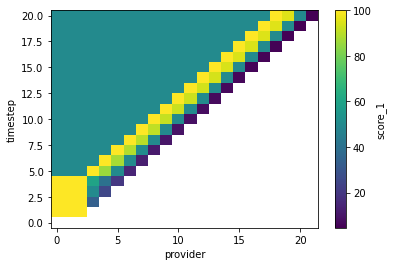

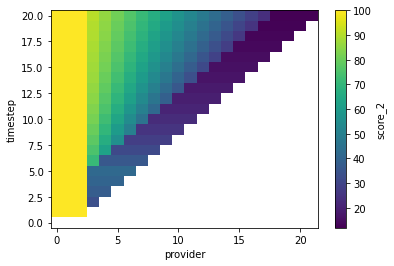

In [266]:
ds.score_1.plot()
plt.show()

ds.score_2.plot()
plt.show()

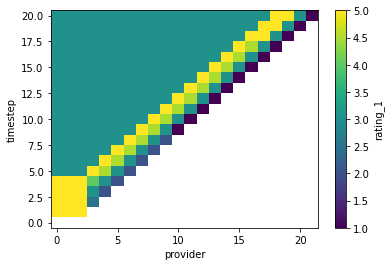

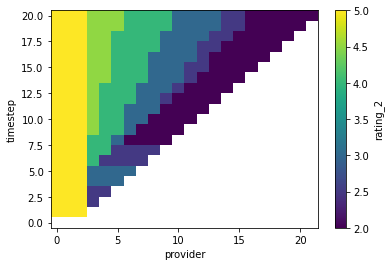

In [267]:
ds.rating_1.plot()
plt.show()

ds.rating_2.plot()
plt.show()

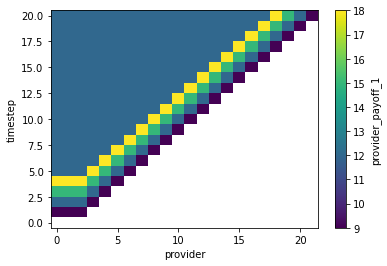

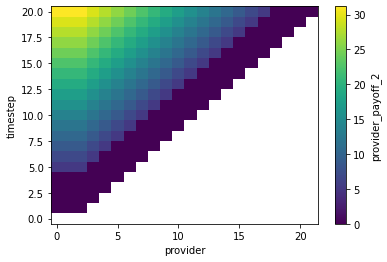

In [268]:
ds.provider_payoff_1.plot()
plt.show()

ds.provider_payoff_2.plot()
plt.show()